In [5]:
#Importing needed libraries
import requests
import pandas as pd
from datetime import datetime
import geopandas as gpd
import time
from json import JSONDecodeError
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from personal_lib import general_functions as gf

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="capstone_test")

In [ ]:
## Use Google Maps or other Services to Geocode the location of buildings
## I made API key; but need to read in my creds for the rest of the geocoding. 
## Spatial Join for Canopy change data from 2010 through 2017
    # - Biggest Decrease
    # - Biggest Increase
    # - Stayed Same
## For those CT, use 2015 tree census data for tree heights / metrics where it matters.
## Spatial Join for limited residential buildings and shaprefile for CT
## Limit geographically the buildings data for increase/ decrease/ same. 
##

## Aggregate counts and tree info for different geographic areas 
## Aggregate / SUmmarize the energy usage metrics, and other building 

### # NYC BUILDING ENERGY DATA 

In [11]:
PAGE = 1000               # <-- enforce 1,000 rows per page
TIMEOUT = 30
MAX_RETRIES = 5
BACKOFF_BASE = 1.5

session = requests.Session()
headers = {}

def fetch_all_rows_1k(api_url: str, source_years: str, source_info_url: str) -> pd.DataFrame:
    offset = 0
    frames = []

    while True:
        params = {"$limit": PAGE, "$offset": offset}

        for attempt in range(1, MAX_RETRIES + 1):
            try:
                resp = session.get(api_url, params=params, headers=headers, timeout=TIMEOUT)
                if resp.status_code in (429, 502, 503, 504):
                    time.sleep(BACKOFF_BASE ** attempt * (0.1 * attempt))
                    continue
                resp.raise_for_status()

                if "json" not in resp.headers.get("Content-Type", "").lower():
                    preview = resp.text[:200]
                    raise ValueError(f"Non-JSON response (status {resp.status_code}): {preview}")

                data_chunk = resp.json()
                if not data_chunk:
                    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

                # Create DataFrame
                df = pd.DataFrame(data_chunk)

                # 🔑 Add your metadata columns here
                df["source_years"] = source_years
                df["source_api_url"] = api_url
                df["source_info_url"] = source_info_url

                frames.append(df)

                # If less than PAGE, stop; otherwise keep paginating
                if len(data_chunk) < PAGE:
                    return pd.concat(frames, ignore_index=True)

                offset += PAGE
                break  # Success, go to next page

            except (requests.RequestException, JSONDecodeError, ValueError) as e:
                if attempt == MAX_RETRIES:
                    print(f"⚠️ Failed fetching {api_url} at offset {offset}: {e}")
                    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
                time.sleep(BACKOFF_BASE ** attempt * (0.1 * attempt))

# --- your existing mapping dict (unchanged) ---
# building_energy_LL84_sources = { ... }  # keep your dict as-is

In [21]:
agg_running_list = []
for k, v in building_energy_LL84_sources.items():
    print(f"Fetching {k} -> {v['api']}")
    df = fetch_all_rows_1k(v["api"], k, v["info"])
    if not df.empty:
        agg_running_list.append(df)
    else:
        print(f"Warning: no rows returned for {k} ({v['api']}).")

nyc_building_energy = pd.concat(agg_running_list, ignore_index=True) if agg_running_list else pd.DataFrame()
print(f"Total rows: {len(nyc_building_energy)}")

Fetching 2022+ -> https://data.cityofnewyork.us/resource/5zyy-y8am.json
Fetching 2021 -> https://data.cityofnewyork.us/resource/7x5e-2fxh.json
Fetching 2020 -> https://data.cityofnewyork.us/resource/usc3-8zwd.json
Fetching 2019 -> https://data.cityofnewyork.us/resource/wcm8-aq5w.json
Fetching 2018 -> https://data.cityofnewyork.us/resource/4tys-3tzj.json
Fetching 2017 -> https://data.cityofnewyork.us/resource/4t62-jm4m.json
Fetching 2016 -> https://data.cityofnewyork.us/resource/utpj-74fz.json
Fetching 2015 -> https://data.cityofnewyork.us/resource/77q4-nkfh.json
Fetching 2014 -> https://data.cityofnewyork.us/resource/nbun-wekj.json
Fetching 2013 -> https://data.cityofnewyork.us/resource/yr5p-wjer.json
Fetching 2012 -> https://data.cityofnewyork.us/resource/r6ub-zhff.json
Fetching 2011 -> https://data.cityofnewyork.us/resource/k7nh-aufb.json
Fetching 2010 -> https://data.cityofnewyork.us/resource/kswi-37bp.json
Fetching Monthly -> https://data.cityofnewyork.us/resource/fvp3-gcb2.json
To

In [2]:
## There are mulitple sources of yearly data. Compiling the source URLs here as well as the API urls to grab
## privately owned buildings over 25,000 ft2 and in City-owned buildings over 10,000 ft2
building_energy_LL84_sources={"2022+":{
    "api":"https://data.cityofnewyork.us/resource/5zyy-y8am.json",
    "info":"https://data.cityofnewyork.us/Environment/NYC-Building-Energy-and-Water-Data-Disclosure-for-/5zyy-y8am/about_data"
                              },
                              "2021":{
    "api":"https://data.cityofnewyork.us/resource/7x5e-2fxh.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/7x5e-2fxh/about_data"
                              },
                              "2020":{
    "api":"https://data.cityofnewyork.us/resource/usc3-8zwd.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/usc3-8zwd/about_data"
                                  },
                              "2019":{
    "api":"https://data.cityofnewyork.us/resource/wcm8-aq5w.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/wcm8-aq5w/about_data"
                                  },
                              "2018":{
    "api":"https://data.cityofnewyork.us/resource/4tys-3tzj.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/4tys-3tzj/about_data"
                                  },
                              "2017":{
    "api":"https://data.cityofnewyork.us/resource/4t62-jm4m.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/4t62-jm4m/about_data"
                                  },
                              "2016":{
    "api":"https://data.cityofnewyork.us/resource/utpj-74fz.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/utpj-74fz/about_data"
                                  },
                              "2015":{
    "api":"https://data.cityofnewyork.us/resource/77q4-nkfh.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/77q4-nkfh/about_data"
                                  },
                              "2014":{
    "api":"https://data.cityofnewyork.us/resource/nbun-wekj.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/nbun-wekj/about_data"
                                  },
                              "2013":{
    "api":"https://data.cityofnewyork.us/resource/yr5p-wjer.json",
    "info":"http://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/yr5p-wjer"
                                  },
                              "2012":{
    "api":"https://data.cityofnewyork.us/resource/r6ub-zhff.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/r6ub-zhff/about_data"
                                  },
                              "2011":{
    "api":"https://data.cityofnewyork.us/resource/k7nh-aufb.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/k7nh-aufb/about_data"
                                  },
                              "2010":{
    "api":"https://data.cityofnewyork.us/resource/kswi-37bp.json",
    "info":"https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/kswi-37bp/about_data"
                                  },
#Monthly Data? 2018-2023
                              "Monthly":{
    "api":"https://data.cityofnewyork.us/resource/fvp3-gcb2.json",
    "info":"https://data.cityofnewyork.us/Environment/Local-Law-84-Monthly-Data/fvp3-gcb2/about_data"
    }}


In [22]:
## Formatting into proper df
print(nyc_building_energy.shape)
## Saving to File
# nyc_building_energy.to_csv("nyc_dob_energy_2010_2024.csv",index=False)

(2044010, 852)


In [14]:
nyc_building_energy=  pd.read_csv("nyc_dob_energy_2010_2024.csv")

C:\Users\johnf\AppData\Local\Temp\ipykernel_32548\1093730636.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,244,245,246,252,253,254,257,258,259,260,261,262,263,264,268,269,270,27

## Cleaning Start

In [ ]:
### Columns to Drop because potentially irrelevant or redundant for 
nyc_building_energy_processing = nyc_building_energy.copy()
# nyc_building_energy_processing = nyc_building_energy_processing.drop(columns=['data_center_ups_output_meter',
#  'data_center_pdu_input_meter',
#  'data_center_pdu_output_meter',
#  'data_center_it_equipment',
#  'data_center_it_site_energy',
#  'data_center_it_source_energy',
#  'data_center_pue',
#  'data_center_national_median',
#  'data_center_gross_floor_area',
#  'data_center_ups_system',
#  'data_center_it_energy',
#  'data_center_cooling_equipment',
# 'supermarkets_grocery_gross',
#  'supermarkets_grocery_number',
#  'supermarkets_grocery_number_1',
#  'supermarkets_grocery_number_2',
#  'supermarkets_grocery_percent',
#  'supermarkets_grocery_presence',
#  'supermarkets_grocery_walk',
#  'supermarkets_grocery_weekly',
#  'supermarkets_grocery_workers',
# 'house_of_worship_gross_floor',
#  'house_of_worship_pc_density',
#  'house_of_worship_weekly',
#  'house_of_worship_presence',
# 'residence_halls_dormitories',
# 'medical_office_percent_cooled',
#  'residence_halls_dormitories_1',
#  'residence_halls_dormitories_2',
#  'residence_halls_dormitories_3',
#  'residence_halls_dormitories_4',
# 'hotel_onsite_laundry_short',
#  'warehouse_unrefrigerated',
#  'warehouse_unrefrigerated_1',
#  'warehouse_unrefrigerated_2',
#  'warehouse_unrefrigerated_3',
#  'warehouse_unrefrigerated_4',
#  'warehouse_unrefrigerated_5',
#  'warehouse_unrefrigerated_6',
#  'hospital_gross_floor_area',
#  'hospital_laboratory_y_1_n',
#  'hospital_laundry_facility',
#  'hospital_maximum_number_of',
#  'hospital_number_of_buildings',
#  'warehouse_refrigerated_gross',
#  'warehouse_refrigerated_weekly',
#  'warehouse_refrigerated_workers',
#  'hospital_number_of_licensed',
#  'multifamily_home_dishwashers'])

## Fruther Limiting to those that are under 10 Stories. 
nyc_building_energy_processing = nyc_building_energy_processing.replace("Not Available",np.nan).dropna(how='all',axis=1)
nyc_building_energy_processing = nyc_building_energy_processing.dropna(how='all',axis=1)

nyc_building_energy_processing["primary_property_type"] = nyc_building_energy_processing["primary_property_type"].combine_first(nyc_building_energy_processing["primary_property_type_epa"])
nyc_building_energy_processing = nyc_building_energy_processing.drop(columns=["primary_property_type_epa"])
nyc_building_energy_processing["primary_property_type_self"] = nyc_building_energy_processing["primary_property_type_self"].combine_first(nyc_building_energy_processing["primary_property_type_self_selected"])
nyc_building_energy_processing = nyc_building_energy_processing.drop(columns=["primary_property_type_self_selected"])



## Beginning of Limiting to Multifamily Homes (Step 1)
residential = nyc_building_energy_processing[(
    (nyc_building_energy_processing["list_of_all_property_use"].isin([i for i in nyc_building_energy_processing["list_of_all_property_use"].unique() if 'Multifamily Housing' in str(i)]))
    |(nyc_building_energy_processing["list_of_all_property_use"].isnull() 
      & (nyc_building_energy_processing["primary_property_type_self"]=="Multifamily Housing")
      & ((nyc_building_energy_processing["primary_property_type"]=="Multifamily Housing")|
         (nyc_building_energy_processing["primary_property_type"].isnull()))))]

In [ ]:
## Beginning of Limiting to Multifamily Homes (Step 1)
residential = nyc_building_energy_processing[(
    (nyc_building_energy_processing["list_of_all_property_use"].isin([i for i in nyc_building_energy_processing["list_of_all_property_use"].unique() if 'Multifamily Housing' in str(i)]))
    |(nyc_building_energy_processing["list_of_all_property_use"].isnull() 
      & (nyc_building_energy_processing["primary_property_type_self"]=="Multifamily Housing")
      & ((nyc_building_energy_processing["primary_property_type"]=="Multifamily Housing")|
         (nyc_building_energy_processing["primary_property_type"].isnull()))))]

In [29]:
residential.shape

(190452, 850)

In [ ]:
## Second Step is limiting to NON MIXED USE, so ONLY MultiFamily Residences
residential = residential[
    residential['list_of_all_property_use'].isnull() |
    residential['list_of_all_property_use'].apply(
        lambda x: len(x.split(",")) == 1 if isinstance(x, str) else False
    )
]
## Fruther Limiting to those that are under 10 Stories. 
residential = residential.replace("Not Available",np.nan).dropna(how='all',axis=1)
residential = residential.dropna(how='all',axis=1)

In [31]:
residential.shape 

(157568, 564)

In [ ]:
## Dropping Other Property Type Columns 
to_drop =[
## Banking oriented COlumns
'bank_branch_computer_density',
 'bank_branch_gross_floor_area',
 'bank_branch_gross_floor_area_ft',
 'bank_branch_number_of',
 'bank_branch_number_of_workers',
 'bank_branch_percent_that',
 'bank_branch_weekly_operating',
 'bank_branch_worker_density',
## College / Uni / School
'college_university_gross',
 'college_university_gross_floor_area_ft',
 'college_university_number',
    'k_12_school_computer_density',
 'k_12_school_cooking_facilities',
 'k_12_school_gross_floor_area',
 'k_12_school_gross_floor_area_ft',
 'k_12_school_high_school',
 'k_12_school_percent_that',
 'k_12_school_refrigeration',
 'k_12_school_weekend_operation',
 'laboratory_gross_floor_area_ft',
    'library_gross_floor_area',
# OTher
"automobile_dealership_gross",
'convenience_store_without',
'data_center_energy_estimates_applied',
 'data_center_gross_floor_area',
 'data_center_gross_floor_area_ft',
 'data_center_it_energy',
 'data_center_it_energy_configuration',
 'data_center_it_equipment_input_meter_kwh',
 'data_center_it_site_energy',
 'data_center_it_site_energy_kwh',
 'data_center_it_source_energy_kbtu',
 'data_center_national_median',
 'data_center_pdu_input_meter_kwh',
 'data_center_pdu_output_meter_kwh',
 'data_center_ups_output_meter_kwh',
 'enclosed_mall_gross_floor',
 'enclosed_mall_gross_floor_area_ft',
 'fast_food_restaurant_gross',
 'financial_office_gross_floor',
 'financial_office_gross_floor_area_ft',
 'financial_office_number_of',
 'financial_office_number_of_1',
 'financial_office_number_of_computers',
 'financial_office_number_of_workers_on_main_shift',
 'financial_office_weekly',
 'financial_office_weekly_operating_hours',
 'fitness_center_health_club',
 'fitness_center_health_club_gym_gross_floor_area_ft',
 'food_sales_gross_floor_area',
 'food_sales_gross_floor_area_ft',
 'food_service_gross_floor',
 'food_service_gross_floor_area_ft',
     'worship_facility_computer',
 'worship_facility_cooking',
 'worship_facility_gross_floor',
 'worship_facility_gross_floor_area_ft',
 'worship_facility_weekly',
    'supermarket_grocery_cooking',
 'supermarket_grocery_gross',
 'supermarket_grocery_gross_floor_area_ft',
 'supermarket_grocery_number',
 'supermarket_grocery_number_1',
 'supermarket_grocery_number_2',
 'supermarket_grocery_number_of_open_or_closed_refrigeration_freezer_units',
 'supermarket_grocery_number_of_walk_in_refrigeration_freezer_units',
 'supermarket_grocery_percent',
 'supermarket_grocery_walk',
 'supermarket_grocery_weekly',
 'supermarket_grocery_worker',
 'swimming_pool_approximate',
 'swimming_pool_location_of',
 'swimming_pool_months_in_use',
     'social_meeting_hall_gross',
 'social_meeting_hall_gross_floor_area_ft',
     'residence_hall_dormitory',
 'residence_hall_dormitory_1',
 'residence_hall_dormitory_2',
 'residence_hall_dormitory_3',
 'residence_hall_dormitory_4',
 'residence_hall_dormitory_gross_floor_area_ft',
 'restaurant_gross_floor_area',
 'restaurant_gross_floor_area_ft',
 'restaurant_weekly_operating',
 'restaurant_weekly_operating_hours',
 'restaurant_worker_density',
 'restaurant_worker_density_number_per_1_000_sq_ft',
 'retail_store_cash_register',
 'retail_store_computer_density',
 'retail_store_exterior_entrance',
 'retail_store_gross_floor',
 'retail_store_gross_floor_area_ft',
 'retail_store_number_of_open',
 'retail_store_number_of_open_or_closed_refrigeration_freezer_units',
 'retail_store_number_of_walk',
 'retail_store_number_of_walk_in_refrigeration_freezer_units',
 'retail_store_open_or_closed',
 'retail_store_percent_that',
 'retail_store_walk_in',
 'retail_store_weekly_operating',
 'retail_store_worker_density',
 'self_storage_facility_gross',
 'self_storage_facility_gross_floor_area_ft',
 'senior_care_community_average',
 'senior_care_community_gross',
 'senior_care_community_maximum',
 'senior_care_community_number',
 'senior_care_community_number_1',
 'senior_care_community_number_2',
 'senior_care_community_number_3',
 'senior_care_community_number_4',
 'senior_care_community_number_5',
 'senior_care_community_number_6',
 'senior_care_community_percent',
 'senior_living_community_gross_floor_area_ft',
 'senior_living_community_living_unit_density_number_per_1_000_sq_ft',
    'movie_theater_gross_floor_area_ft',
    'non_refrigerated_warehouse',
 'non_refrigerated_warehouse_1',
 'non_refrigerated_warehouse_2',
 'non_refrigerated_warehouse_3',
 'non_refrigerated_warehouse_4',
 'non_refrigerated_warehouse_5',
 'non_refrigerated_warehouse_gross_floor_area_ft',
     'parking_completely_enclosed',
 'parking_completely_enclosed_parking_garage_size_ft',
 'parking_gross_floor_area',
 'parking_gross_floor_area_ft',
 'parking_open_parking_lot',
 'parking_open_parking_lot_size_ft',
 'parking_partially_enclosed',
 'parking_partially_enclosed_parking_garage_size_ft',
     'strip_mall_gross_floor_area',
## Hostpial / Hotel
    'hospital_general_medical',
 'hospital_general_medical_1',
 'hospital_general_medical_10',
 'hospital_general_medical_11',
 'hospital_general_medical_12',
 'hospital_general_medical_13',
 'hospital_general_medical_14',
 'hospital_general_medical_15',
 'hospital_general_medical_16',
 'hospital_general_medical_17',
 'hospital_general_medical_2',
 'hospital_general_medical_3',
 'hospital_general_medical_4',
 'hospital_general_medical_5',
 'hospital_general_medical_6',
 'hospital_general_medical_7',
 'hospital_general_medical_8',
 'hospital_general_medical_9',
 'hotel_amount_of_laundry',
 'hotel_cooking_facilities',
 'hotel_full_service_spa_floor',
 'hotel_gross_floor_area_ft',
 'hotel_gym_fitness_center',
 'hotel_gym_fitness_center_floor_area_ft',
 'hotel_number_of_rooms',
 'hotel_percent_that_can_be',
 'hotel_room_density_number',
 'hotel_type_of_laundry_facility',
 'hotel_worker_density_number',
 'urgent_care_clinic_other',
 'urgent_care_clinic_other_outpatient_gross_floor_area_ft',
    'mailing_center_post_office_gross_floor_area_ft',
 'manufacturing_industrial_plant_gross_floor_area_ft',
 'medical_office_gross_floor',
 'medical_office_gross_floor_area_ft',
 'medical_office_mri_machine',
 'medical_office_number_of',
 'medical_office_number_of_1',
 'medical_office_number_of_computers',
 'medical_office_number_of_mri_machines',
 'medical_office_number_of_workers_on_main_shift',
 'medical_office_percent_that',
 'medical_office_percent_that_1',
 'medical_office_percent_that_can_be_cooled',
 'medical_office_percent_that_can_be_heated',
 'medical_office_weekly',
 'medical_office_weekly_operating_hours',
    'museum_gross_floor_area_ft',
    'office_computer_density_number',
 'office_gross_floor_area_ft',
 'office_number_of_computers',
 'office_number_of_workers',
 'office_number_of_workers_on_main_shift',
 'office_percent_that_can_be',
 'office_percent_that_can_be_1',
 'office_percent_that_can_be_cooled',
 'office_percent_that_can_be_heated',
 'office_weekly_operating_hours',
 'office_worker_density_number',
 'office_worker_density_number_per_1_000_sq_ft',
     'adult_education_gross_floor',
 'adult_education_gross_floor_area_ft',
]
residential2 = residential.drop(columns=to_drop)

In [ ]:
# Convert year_ending to datetime
residential2["year_ending"] = pd.to_datetime(residential2["year_ending"], errors="coerce")
# Optional: extract just the year if that’s all you need
residential2["year_ending_year"] = residential2["year_ending"].dt.year
residential2[["report_year","year_ending_year","source_years","source_api_url","source_info_url"]][residential['report_year'].isnull()]
## Limtiing to the Metered Areas for whole property or whole building
residential3 = residential2[residential2["metered_areas_energy"].isin(['Whole Building', "Whole Property"])]
residential3 = residential3[residential3["primary_property_type_self"]=='Multifamily Housing'] ## confirming onlyl multifam. No nulls here

residential3 = residential3[(residential3["construction_status"]=='Existing')|(residential3["construction_status"].isnull())]
## Stand Alone Properties
residential3 = residential3[(residential3["parent_property_id"].isnull())|(residential3["parent_property_id"]=='Not Applicable: Standalone Property')]
residential3 = residential3.drop(columns=["primary_property_type_self",
                                          "primary_property_type",
                                          "national_median_reference",
                                          "list_of_all_property_use","largest_property_use_type","construction_status",
                                         "parent_property_id","parent_property_name"])



In [ ]:
### Dropping those that are >=10 stories
residential3[residential3["multifamily_housing_number_of_residential_living_units_in_a_high_rise_building_10_or_more_stories"].isnull()]

In [ ]:
[["energy_star_score","site_energy_use_kbtu","source_energy_use_kbtu"]]

In [ ]:
green_power_onsite_kwh 	green_power_offsite_kwh,green_power_onsite_and_offsite 	

total_location_based_ghg, total_location_based_ghg_1, net_emissions_metric_tons

avoided_emissions_offsite 	avoided_emissions_onsite_

national_median_total_location


 alert_energy_meter_has_gaps, alert_energy_meter_ha, alert_energy_no_meters

In [ ]:
### Geocode The Null lat long 
with_coord = residential3[(~residential3['latitude'].isnull())&(~residential3['longitude'].isnull())]
print(with_coord.shape)
without_coord = residential3[(residential3['latitude'].isnull())|(residential3['longitude'].isnull())]
print(without_coord.shape)

In [16]:
results = []
failed = []

In [58]:
# results_df = pd.concat(results)
# results_df.to_csv("results_geo.csv",index=False)
results_df = pd.read_csv("results_geo.csv")
# failed_df = pd.concat(failed)
# failed_df.to_csv("failed_geo.csv",index=False)
failed_df = pd.read_csv("failed_geo.csv")

In [54]:
# results2 = pd.concat(results)
# failed2 = pd.concat(failed)
# results_df = pd.concat([results2,results_df])
# failed_df = pd.concat([failed2,failed_df])

In [15]:
without_coord.head()

,report_year,property_id,property_name,year_ending,nyc_borough_block_and_lot,nyc_building_identification,address_1,city,postal_code,largest_property_use_type_1,...,energy_current_date,electricity_onsite_renewable,electricity_sourced_from,onsite_renewable_system,target_site_eui_kbtu_ft,other_use_kbtu,estimated_data_flag_other,bin,bbl,year_ending_year
21,2022.0,15327445.0,KM 1200 Union Ave/1204 Union Ave,2022-12-31,2026820001,2005057,1200 Union Ave/1204 Union Ave,Bronx,10459,37672.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
24,2022.0,15332746.0,KM 500 West 144th street/144 Hamilton Place,2022-12-31,1020750036,1061888,500 West 144th street/144 Hamilton Place,New York,10031,56688.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
84,2022.0,24125286.0,2820 Middle Town Road,2022-12-31,2053860017,2074435,2820 Middle Town Road,Bronx,10461,25200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
161,2022.0,2771721.0,91-32/34 195th St LLC,2022-12-31,4108210060,4231514;4451927,91-32/34 195th Street,Queens,11423,79709.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
199,2022.0,2638326.0,Marben Realty,2022-12-31,1018900064,1057200,308 West104,New York,10025,56555.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022


In [4]:


creds = gf.get_creds()
google_api_key = creds["Google"]["geocoding"]



In [ ]:
get_creds

In [20]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my_geocoder", timeout=10)


In [19]:

for i, r in without_coord[["property_id","address_1","city","postal_code"]].drop_duplicates().iterrows():
    if i>= 7665:
        temp_df = pd.DataFrame([r])
        print(r["property_id"])
        full_address = str(r["address_1"])+" "+ str(r["city"])+" "+str(r["postal_code"])
        full_address = full_address.replace("nan","")
        print(full_address)
        if '/' in full_address:
            full_address = full_address.split('/')[-1]
            print("Split Addy:",full_address)
        location = geolocator.geocode(full_address)
        if location:
            temp_df["latitude"] = location.latitude
            temp_df["longitude"]= location.longitude
            print(location.latitude, location.longitude)
            results.append(temp_df)
        else:
            failed.append(temp_df)

20452554.0
155-55 Cross Beach Blvd Queens 11414


GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=155-55+Cross+Beach+Blvd+Queens+11414&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [64]:
i

7665

In [ ]:
>>> geolocator = Nominatim(user_agent="capstone_test")
>>> location = geolocator.geocode("175 5th Avenue NYC")
>>> print(location.address)
Flatiron Building, 175, 5th Avenue, Flatiron, New York, NYC, New York, ...
>>> print((location.latitude, location.longitude))
(40.7410861, -73.9896297241625)
>>> print(location.raw)
{'place_id': '9167009604', 'type': 'attraction', ...}

In [123]:
### Placing thie DF into a CSV in order to shelve for now. I need to process tree data first and then identify some buildings that are good for this analsyos.

# residential3.to_csv("residential3.csv",index=False)



### Redsidential 3 import from CSV 

In [9]:
residential3 = pd.read_csv("residential3.csv")

C:\Users\johnf\AppData\Local\Temp\ipykernel_32548\1482399432.py:1: DtypeWarning: Columns (4,5,8,14,18,19,20,43,44,45,46,47,53,54,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,98,112,118,126,127,128,129,130,131,132,133,138,139,146,147,148,151,154,155,156,160,163,172,173,175,176,177,178,179,180,181,183,185,188,189,190,210,211,231,245,247,248,249,250,251,252,253,254,255,256,257,258,259,260,272,273,274,275,276,277,281,282,286,289,295,296,303,304,305,306,307,308,309,318,319,333,334,335,336,337,339,342,345,347,348,352) have mixed types. Specify dtype option on import or set low_memory=False.
  residential3 = pd.read_csv("residential3.csv")


In [10]:
### Geocode The Null lat long 
with_coord = residential3[(~residential3['latitude'].isnull())&(~residential3['longitude'].isnull())]
print(with_coord.shape)
without_coord = residential3[(residential3['latitude'].isnull())|(residential3['longitude'].isnull())]
print(without_coord.shape)

(130321, 362)
(4377, 362)


In [125]:

# residential3[residential3["multifamily_housing_number_of_residential_living_units_in_a_high_rise_building_10_or_more_stories"].isnull()]
# multifamily_housing_number_of_residential_living_units_in_a_mid_rise_building_5_9_stories

In [80]:
## property id is never null. Using this to loop through.
# for property_id in residential["property_id"].unique()[:10]:
#     print(property_id)
#     temp_prop_df = residential[residential["property_id"]==property_id]
#     break
# temp_prop_df = temp_prop_df.dropna(how='all',axis=1)
# for year in temp_prop_df['year'].unique():
#     print(year)
#     single_yr_temp_prop_df = temp_prop_df[temp_prop_df['year']==year]
#     break

9793770


### Foresty Tree Points 

In [ ]:

forestry = {
    "ALL":{
        "api":"https://data.cityofnewyork.us/resource/hn5i-inap.json",
        "info":"https://data.cityofnewyork.us/Environment/Forestry-Tree-Points/hn5i-inap/about_data"
    }
}

In [65]:
# import pandas as pd
# import requests

api_url = "https://data.cityofnewyork.us/resource/hn5i-inap.json"
limit = 50000
offset = 0

frames = []

while True:
    url = f"{api_url}?$limit={limit}&$offset={offset}"
    resp = requests.get(url)
    data = resp.json()
    if not data:
        break
    frames.append(pd.DataFrame(data))
    offset += limit
    print(f"Fetched {offset} rows...")

df_forestry = pd.concat(frames, ignore_index=True)
print("Total rows:", len(df_forestry))


Fetched 50000 rows...
Fetched 100000 rows...
Fetched 150000 rows...
Fetched 200000 rows...
Fetched 250000 rows...
Fetched 300000 rows...
Fetched 350000 rows...
Fetched 400000 rows...
Fetched 450000 rows...
Fetched 500000 rows...
Fetched 550000 rows...
Fetched 600000 rows...
Fetched 650000 rows...
Fetched 700000 rows...
Fetched 750000 rows...
Fetched 800000 rows...
Fetched 850000 rows...
Fetched 900000 rows...
Fetched 950000 rows...
Fetched 1000000 rows...
Fetched 1050000 rows...
Fetched 1100000 rows...
Total rows: 1091042


In [69]:
df_forestry['tpcondition'].unique()

array(['Excellent', 'Good', 'Poor', 'Fair', 'Dead', 'Critical', 'Unknown',
       nan], dtype=object)

In [21]:
## Saving
# df_forestry.to_csv("df_forestry.csv",index=False)
df_forestry = pd.read_csv("df_forestry.csv")

In [22]:
df_forestry

,objectid,dbh,tpstructure,tpcondition,plantingspaceglobalid,geometry,globalid,genusspecies,createddate,updateddate,location,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,riskrating,riskratingdate,planteddate,stumpdiameter
0,86823,20.0,Full,Excellent,E814CD37-9F53-4D79-AF86-3B454F9D29B9,POINT(-73.81656874596392 40.716290654685075),2B457A4C-E0E4-4E17-81C4-A5449F51C804,Acer nigrum - black maple,2015-02-28 05:00:00.0000000,2016-10-20 17:43:53.0000000,"{'type': 'Point', 'coordinates': [-73.81656874...",24670.0,25.0,3.0,24.0,65.0,NaN,NaN,NaN,NaN
1,87623,10.0,Retired,Good,A644AB79-A3CB-4F7F-923B-F308E615CCD4,POINT(-73.93848036135195 40.81299277914583),37195E1A-A7EE-4AA4-8389-19A0ED5C46F7,Fraxinus pennsylvanica - Green ash,2015-03-03 05:00:00.0000000,2019-09-18 13:12:55.0000000,"{'type': 'Point', 'coordinates': [-73.93848036...",13095.0,18.0,4.0,36.0,20.0,NaN,NaN,NaN,NaN
2,88023,24.0,Retired,Poor,21431016-EDB8-4A0B-B122-673125800C87,POINT(-73.8324418090213 40.88762504315543),6BA8E72B-1901-4EF3-ABFF-D11680AB4A9B,Acer platanoides - Norway maple,2015-03-03 05:00:00.0000000,2018-03-27 14:00:42.0000000,"{'type': 'Point', 'coordinates': [-73.83244180...",11275.0,29.0,5.0,2.0,30.0,NaN,NaN,NaN,NaN
3,88823,10.0,Full,Fair,96FB6C55-612F-466D-9449-85A3CD2178E1,POINT(-74.20903635163978 40.519577813518666),79A5DBAF-F305-4DA1-A4B1-7A8C8D085435,Pyrus calleryana - Callery pear,2015-03-04 05:00:00.0000000,2024-06-28 12:41:55.0000000,"{'type': 'Point', 'coordinates': [-74.20903635...",10696.0,15.0,1.0,9.0,77.0,6.0,2024-06-28 12:41:55.0000000,NaN,NaN
4,88824,10.0,Retired,Dead,4796B64F-906C-4345-A4E9-5CD6133642F8,POINT(-73.98032166282525 40.7429106380851),182F6647-D9C1-4A45-ADA0-9ADEFD1ECC60,Gleditsia triacanthos var. inermis - Thornless...,2015-03-04 05:00:00.0000000,2016-10-24 02:50:43.0000000,"{'type': 'Point', 'coordinates': [-73.98032166...",12078.0,71.0,4.0,50.0,7.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091037,16676389,19.0,Full,Fair,A74F111D-D8BD-4C24-B12B-359A05DBAE4E,POINT(-74.08710778257998 40.6392972431061),6A91E5F7-336F-4636-9E0D-B11D8A7511FF,Morus - mulberry,2025-10-01 14:04:39.0000000,2025-10-01 14:05:23.0000000,"{'type': 'Point', 'coordinates': [-74.08710778...",10369.0,4.0,1.0,13.0,74.0,12.0,2025-10-01 14:05:23.0000000,NaN,NaN
1091038,16676390,22.0,Full,Fair,58E2EB4D-C8DC-45CD-BECC-AABD98CD0512,POINT(-74.08731091533897 40.64724258670864),8AA4C9B8-C818-4254-97D4-8B9F975DCF8F,Platanus x acerifolia - London planetree,2025-10-01 15:08:21.0000000,2025-10-01 15:09:02.0000000,"{'type': 'Point', 'coordinates': [-74.08731091...",10369.0,4.0,1.0,13.0,74.0,12.0,2025-10-01 15:09:02.0000000,NaN,NaN
1091039,16676391,18.0,Full,Fair,27707E4A-090F-462E-85A0-AF81AFAD701B,POINT(-74.0871757526539 40.64743865488903),98A2C1F4-65B3-4A7C-B144-B2739BABF2EF,Ulmus americana - American elm,2025-10-01 16:24:07.0000000,2025-10-01 16:28:30.0000000,"{'type': 'Point', 'coordinates': [-74.08717575...",10369.0,4.0,1.0,13.0,74.0,12.0,2025-10-01 16:28:30.0000000,NaN,NaN
1091040,16676392,16.0,Full,Fair,A85FECBF-33FD-4A72-BE93-B021F004A070,POINT(-74.08713763689435 40.64737883430869),D26E13BB-E898-47CA-9798-E121A87D9A8E,Ulmus americana - American elm,2025-10-01 16:20:02.0000000,2025-10-01 16:21:01.0000000,"{'type': 'Point', 'coordinates': [-74.08713763...",10369.0,4.0,1.0,13.0,74.0,12.0,2025-10-01 16:21:01.0000000,NaN,NaN


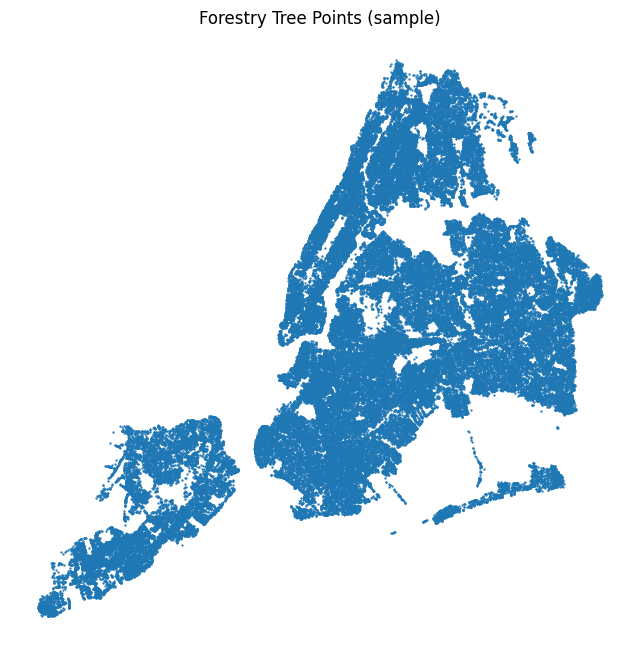

In [68]:
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# Build a GeoDataFrame from WKT geometry (EPSG:4326)
pts = df_forestry.dropna(subset=["geometry"]).copy()
pts["geometry"] = gpd.GeoSeries.from_wkt(pts["geometry"])
gdf = gpd.GeoDataFrame(pts, geometry="geometry", crs=4326)

# Sample (plotting all ~1M points can be slow)
gdf_sample = gdf.sample(min(100_000, len(gdf)), random_state=0)

ax = gdf_sample.plot(markersize=0.4, figsize=(8, 8))
ax.set_title("Forestry Tree Points (sample)")
ax.set_axis_off()
plt.show()


## Canopy Change 2010 Through 2017

In [ ]:
### Forestry Work Ordwrs for Tree Removal? 
# https://data.cityofnewyork.us/Environment/Forestry-Work-Orders/bdjm-n7q4/about_data

### NYC Tax Zoning 

In [52]:
tax_zoning = {
    "ALL":{
        "api":"https://data.cityofnewyork.us/resource/fdkv-4t4z.json",
        "info":"https://data.cityofnewyork.us/City-Government/NYC-Zoning-Tax-Lot-Database/fdkv-4t4z/about_data"
}

SyntaxError: incomplete input (940578819.py, line 5)

In [ ]:
PAGE = 1000               # <-- enforce 1,000 rows per page
TIMEOUT = 30
MAX_RETRIES = 5
BACKOFF_BASE = 1.5

session = requests.Session()
headers = {}

agg_running_list = []
for k, v in tax_zoning.items():
    print(f"Fetching {k} -> {v['api']}")
    df = fetch_all_rows_1k(v["api"], k, v["info"])
    if not df.empty:
        agg_running_list.append(df)
    else:
        print(f"Warning: no rows returned for {k} ({v['api']}).")

nyc_tax_zoning = pd.concat(agg_running_list, ignore_index=True) if agg_running_list else pd.DataFrame()
print(f"Total rows: {len(nyc_tax_zoning)}")


In [ ]:
nyc_tax_zoning.to_csv("nyc_tax_zoning.csv", index=False )

### Tree Census

In [9]:
### Pulling Tree Census Data Data
tree_census ={
    "1995":{
        "api":"https://data.cityofnewyork.us/resource/kyad-zm4j.json",
        "info":"https://data.cityofnewyork.us/Environment/1995-Street-Tree-Census/kyad-zm4j/about_data"
    },
    "2005":{
        "api":"https://data.cityofnewyork.us/resource/29bw-z7pj.json",
        "info":"https://data.cityofnewyork.us/Environment/2005-Street-Tree-Census/29bw-z7pj/about_data"
    },
    "2015":{
        "api":"https://data.cityofnewyork.us/resource/uvpi-gqnh.json",
        "info":"https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh/about_data"
    }
}
### Need to add 2025 When Available. 

In [12]:
PAGE = 1000               # <-- enforce 1,000 rows per page
TIMEOUT = 30
MAX_RETRIES = 5
BACKOFF_BASE = 1.5

session = requests.Session()
headers = {}

agg_running_list = []
for k, v in tree_census.items():
    print(f"Fetching {k} -> {v['api']}")
    df = fetch_all_rows_1k(v["api"], k, v["info"])
    if not df.empty:
        agg_running_list.append(df)
    else:
        print(f"Warning: no rows returned for {k} ({v['api']}).")

nyc_tree_census = pd.concat(agg_running_list, ignore_index=True) if agg_running_list else pd.DataFrame()
print(f"Total rows: {len(nyc_tree_census)}")


Fetching 1995 -> https://data.cityofnewyork.us/resource/kyad-zm4j.json
Fetching 2005 -> https://data.cityofnewyork.us/resource/29bw-z7pj.json
Fetching 2015 -> https://data.cityofnewyork.us/resource/uvpi-gqnh.json
Total rows: 1793149


In [24]:
pd.options.display.max_columns =599
nyc_tree_census[nyc_tree_census['longitude'].isnull()|
 nyc_tree_census['latitude'].isnull()]

,recordid,address,house_number,street,zip_original,cb_original,site,species,diameter,condition,wires,sidewalk_condition,support_structure,borough,x,y,longitude,latitude,cb_new,zip_new,censustract_2010,censusblock_2010,nta_2010,segmentid,spc_common,spc_latin,location,council_district,bin,bbl,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,source_years,source_api_url,source_info_url,objectid,cen_year,tree_dbh,tree_loc,pit_type,soil_lvl,status,vert_other,vert_pgrd,vert_tgrd,vert_wall,horz_blck,horz_grate,horz_plant,horz_other,sidw_crack,sidw_raise,wire_htap,wire_prime,wire_2nd,wire_other,inf_canopy,inf_guard,inf_wires,inf_paving,inf_outlet,inf_shoes,inf_lights,inf_other,trunk_dmg,zipcode,zip_city,cb_num,borocode,boroname,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,x_sp,y_sp,objectid_1,census_tract,location_1,tree_id,block_id,created_at,stump_diam,curb_loc,health,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other


In [26]:
nyc_tree_census.head() to csv

,recordid,address,house_number,street,zip_original,cb_original,site,species,diameter,condition,wires,sidewalk_condition,support_structure,borough,x,y,longitude,latitude,cb_new,zip_new,censustract_2010,censusblock_2010,nta_2010,segmentid,spc_common,spc_latin,location,council_district,bin,bbl,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,source_years,source_api_url,source_info_url,objectid,cen_year,tree_dbh,tree_loc,pit_type,soil_lvl,status,vert_other,vert_pgrd,vert_tgrd,vert_wall,horz_blck,horz_grate,horz_plant,horz_other,sidw_crack,sidw_raise,wire_htap,wire_prime,wire_2nd,wire_other,inf_canopy,inf_guard,inf_wires,inf_paving,inf_outlet,inf_shoes,inf_lights,inf_other,trunk_dmg,zipcode,zip_city,cb_num,borocode,boroname,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,x_sp,y_sp,objectid_1,census_tract,location_1,tree_id,block_id,created_at,stump_diam,curb_loc,health,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other
0,1,245 E 17 ST,245,E 17 ST,10003,106,Front,PLAC,8,Unknown,None,NA,None,Manhattan,988618.9688,206893.764,-73.984235,40.734551,106,10003,48,2000,MN21,33134,LONDON PLANETREE,PLATANUS ACERIFOLIA,"{'latitude': '40.734551', 'longitude': '-73.98...",2,1019566,1008980025,11724,71,4,50,7,1995,https://data.cityofnewyork.us/resource/kyad-zm...,https://data.cityofnewyork.us/Environment/1995...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,80 N MOORE ST,80,N MOORE ST,10013,101,Side,ACPL,7,Good,None,Good,None,Manhattan,981330.4271,201649.9518,-74.010532,40.720159,101,10013,39,2001,MN24,31567,"MAPLE, NORWAY",ACER PLATANOIDES,"{'latitude': '40.720159', 'longitude': '-74.01...",1,1083157,1001420025,12076,56,4,32,1,1995,https://data.cityofnewyork.us/resource/kyad-zm...,https://data.cityofnewyork.us/Environment/1995...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,80 N MOORE ST,80,N MOORE ST,10013,101,Side,ACPL,6,Good,None,Good,None,Manhattan,981330.4271,201649.9518,-74.010532,40.720159,101,10013,39,2001,MN24,31567,"MAPLE, NORWAY",ACER PLATANOIDES,"{'latitude': '40.720159', 'longitude': '-74.01...",1,1083157,1001420025,12076,56,4,32,1,1995,https://data.cityofnewyork.us/resource/kyad-zm...,https://data.cityofnewyork.us/Environment/1995...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,80 N MOORE ST,80,N MOORE ST,10013,101,Side,ACPL,7,Excellent,None,Good,None,Manhattan,981330.4271,201649.9518,-74.010532,40.720159,101,10013,39,2001,MN24,31567,"MAPLE, NORWAY",ACER PLATANOIDES,"{'latitude': '40.720159', 'longitude': '-74.01...",1,1083157,1001420025,12076,56,4,32,1,1995,https://data.cityofnewyork.us/resource/kyad-zm...,https://data.cityofnewyork.us/Environment/1995...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,80 N MOORE ST,80,N MOORE ST,10013,101,Side,ACPL,6,Good,None,Good,None,Manhattan,981330.4271,201649.9518,-74.010532,40.720159,101,10013,39,2001,MN24,31567,"MAPLE, NORWAY",ACER PLATANOIDES,"{'latitude': '40.720159', 'longitude': '-74.01...",1,1083157,1001420025,12

In [13]:
# nyc_tree_census.to_csv("NYC_tree_census.csv", index=False )

In [ ]:
nyc_tree_census= pd.read_csv("NYC_tree_census.csv")

In [ ]:
# Canopy Change (2010 - 2017)

In [23]:
import geopandas as gpd
import fiona
# Path to your geodatabase (.gdb)
gdb_path = r"C:\Users\johnf\Downloads\Tree_Canopy_Change (1)\Tree_Canopy_Change\NYC_TreeCanopyChange_2010_2017.gdb"

# List all layers in the geodatabase
layers = fiona.listlayers(gdb_path)
print("Layers available:", layers)

# Read a specific layer into a GeoDataFrame
gdf = gpd.read_file(gdb_path, layer=layers[0])  # Replace [0] with your desired layer
print(gdf.head())

# Optional: save as shapefile or GeoJSON
#gdf.to_file("output.shp") 
#gdf.to_file("output.geojson", driver="GeoJSON")


Layers available: ['NYC_TreeCanopyChange_2010_2017']


C:\Python310\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


       Class  Shape_Length    Shape_Area  \
0  No Change    732.955182   5800.500001   
1  No Change   2079.456465  35005.875002   
2  No Change    228.557599   1984.500000   
3  No Change    125.726893    617.750000   
4  No Change     41.031601     90.750000   

                                            geometry  
0  MULTIPOLYGON (((1008879.93 272372.3, 1008878.4...  
1  MULTIPOLYGON (((1008749.43 271870.8, 1008748.9...  
2  MULTIPOLYGON (((1008704.43 272105.3, 1008701.9...  
3  MULTIPOLYGON (((1009015.43 272757.3, 1009013.4...  
4  MULTIPOLYGON (((1008794.93 270669.8, 1008781.4...  


In [31]:
decrease_canopy = gdf[gdf['Class']=='Loss']

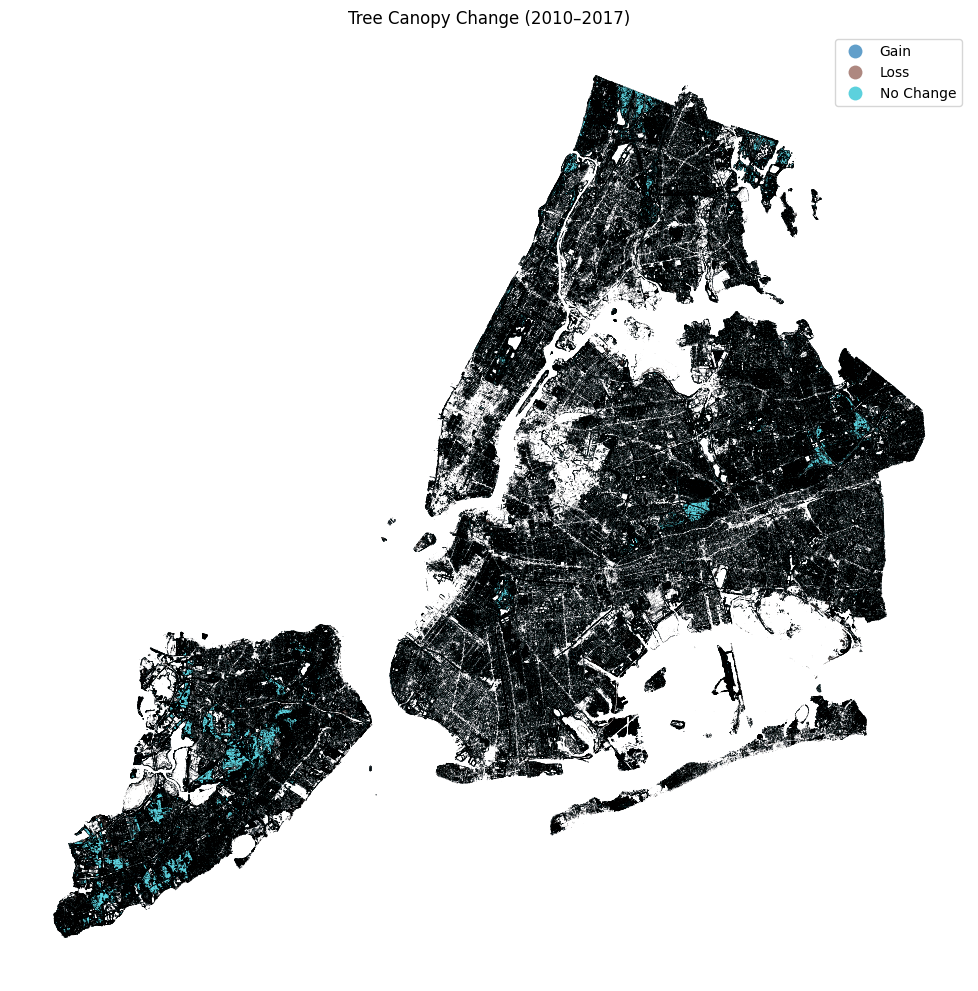

In [24]:
import matplotlib.pyplot as plt

# If geometries are invalid, this fixes many issues
gdf = gdf.set_geometry(gdf.geometry.buffer(0))

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    ax=ax,
    column="Class",          # categorical: "Change", "No Change"
    categorical=True,
    alpha=0.7,
    linewidth=0.2,
    edgecolor="black",
    legend=True,
)
ax.set_axis_off()
ax.set_title("Tree Canopy Change (2010–2017)")
plt.tight_layout()
plt.show()


AttributeError: Stamen

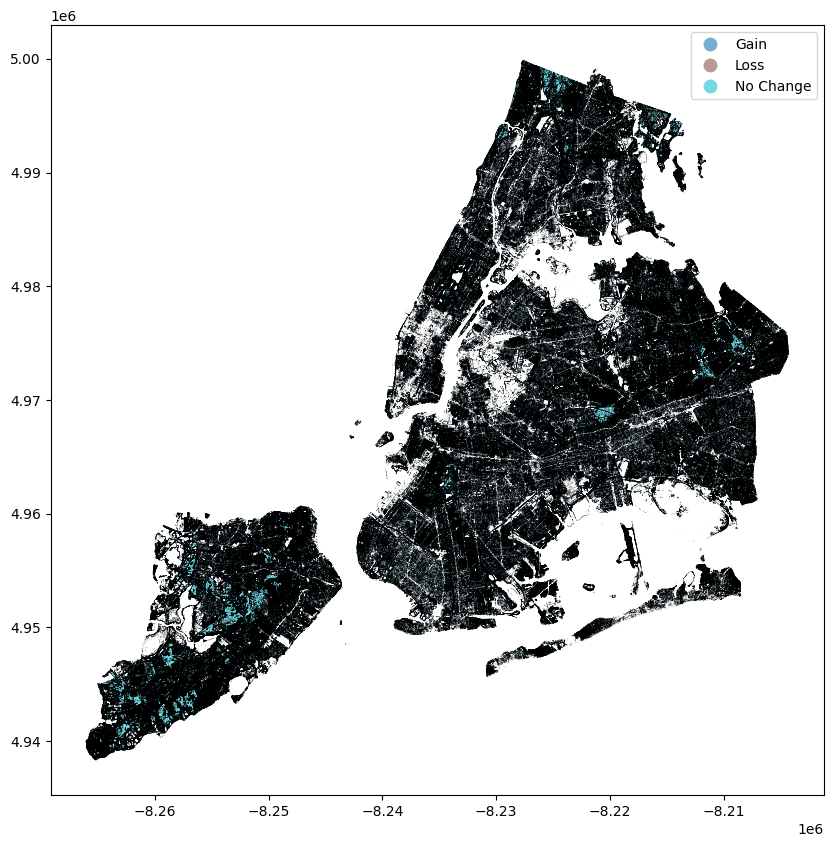

In [25]:
# pip install contextily
import contextily as ctx

# Reproject to Web Mercator (required for contextily)
gdf_3857 = gdf.to_crs(3857)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_3857.plot(
    ax=ax,
    column="Class",
    categorical=True,
    alpha=0.6,
    linewidth=0.2,
    edgecolor="black",
    legend=True,
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)  # pick any provider
ax.set_axis_off()
ax.set_title("Tree Canopy Change over Basemap")
plt.tight_layout()
plt.show()


In [ ]:
creds

In [ ]:
# NYC 2010 Census Tract Shapefiles

In [3]:
import io, requests, geopandas as gpd

CT2010_URL = "https://data.cityofnewyork.us/resource/bmjq-373p.geojson?$limit=50000"
SOCRATA_APP_TOKEN = None  # put your token string here if you have one

headers = {"X-App-Token": SOCRATA_APP_TOKEN} if SOCRATA_APP_TOKEN else {}
resp = requests.get(CT2010_URL, headers=headers, timeout=60)
resp.raise_for_status()

ct2010 = gpd.read_file(io.BytesIO(resp.content)).to_crs(2263)
ct2010.head()


,ntacode,shape_area,ntaname,shape_leng,boroname,puma,boroct2010,ct2010,borocode,cdeligibil,ctlabel,geometry
0,SI22,2497009.71359,West New Brighton-New Brighton-St. George,7729.01679383,Staten Island,3903,5000900,000900,5,E,9,"MULTIPOLYGON (((962269.126 173705.5, 962288.72..."
1,MN17,1860992.68163,Midtown-Midtown South,5687.80243891,Manhattan,3807,1010200,010200,1,I,102,"MULTIPOLYGON (((992216.539 216507.687, 992091...."
2,MN17,1864600.43538,Midtown-Midtown South,5693.03636707,Manhattan,3807,1010400,010400,1,I,104,"MULTIPOLYGON (((991325.882 217001.689, 991199...."
3,MN17,1890907.25105,Midtown-Midtown South,5699.86064037,Manhattan,3807,1011300,011300,1,I,113,"MULTIPOLYGON (((988650.277 214286.402, 988517...."
4,MN40,1918144.56374,Upper East Side-Carnegie Hill,5807.97295649,Manhattan,3805,1013000,013000,1,I,130,"MULTIPOLYGON (((994920.11 221386.27, 994791.85..."


In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def tag_with_census_tract(
    points_df: pd.DataFrame,
    lon_col: str = "longitude",
    lat_col: str = "latitude",
    tracts_gdf: gpd.GeoDataFrame = None,
    tract_cols: list | None = None,
    crs_points: int = 4326,   # your points are lon/lat
    crs_working: int = 2263   # NYC State Plane feet; consistent + accurate for joins
) -> gpd.GeoDataFrame:
    """
    Returns a GeoDataFrame of points joined with tract attributes.
    `tract_cols` controls which tract fields to keep (e.g., ['boro_name','boroct2010','geoid10']).
    """
    assert tracts_gdf is not None, "Provide a tracts GeoDataFrame."

    # Build points GeoDataFrame (drop rows without valid coords)
    pts = points_df.dropna(subset=[lon_col, lat_col]).copy()
    pts = gpd.GeoDataFrame(
        pts,
        geometry=gpd.points_from_xy(pts[lon_col], pts[lat_col], crs=crs_points)
    ).to_crs(crs_working)

    # Ensure tracts are in the same CRS
    tr = tracts_gdf.to_crs(crs_working)

    # Columns to keep from tracts
    if tract_cols is None:
        # If you’re not sure which columns carry the tract ID, keep a few common ones
        cand = [c for c in tr.columns if c.lower() in {"boro_name","borough","boroct2010","geoid10","tract","ntacode","ntaname"}]
        tract_cols = list(dict.fromkeys(["boro_name","boroct2010","geoid10"] + cand))  # de-dup while keeping order
        tract_cols = [c for c in tract_cols if c in tr.columns]

    # Spatial join: which tract polygon each point falls within
    out = gpd.sjoin(
        pts,
        tr[tract_cols + ["geometry"]],
        how="left",
        predicate="within"
    ).drop(columns=["index_right"])

    return out


In [5]:
import geopandas as gpd

# 1) Read census tracts (2010) via GeoJSON; set to a working CRS
CT2010_URL = "https://data.cityofnewyork.us/resource/bmjq-373p.geojson?$limit=50000"
ct2010 = gpd.read_file(CT2010_URL)  # will be EPSG:4326
# (we'll convert inside the helper)

# 2) Suppose you have two point datasets:
#    df_a with columns ['id','latitude','longitude', ...]
#    df_b with columns ['site','lat','lon', ...]
# Tag both with tracts
streetTree_with_tract = tag_with_census_tract(nyc_tree_census, lon_col="longitude", lat_col="latitude", tracts_gdf=ct2010)
# b_with_tract = tag_with_census_tract(df_b, lon_col="lon",       lat_col="lat",      tracts_gdf=ct2010)

# Peek
streetTree_with_tract[["id","boroct2010","geoid10"]].head()
# b_with_tract[["site","boroct2010","geoid10"]].head()


NameError: name 'nyc_tree_census' is not defined

In [30]:
### Need to finish geocoding the street trees 
streetTree_with_tract[streetTree_with_tract["boroct2010"].isnull()]

,recordid,address,house_number,street,zip_original,cb_original,site,species,diameter,condition,wires,sidewalk_condition,support_structure,borough,x,y,longitude,latitude,cb_new,zip_new,censustract_2010,censusblock_2010,nta_2010,segmentid,spc_common,spc_latin,location,council_district,bin,bbl,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,source_years,source_api_url,source_info_url,objectid,cen_year,tree_dbh,tree_loc,pit_type,soil_lvl,status,vert_other,vert_pgrd,vert_tgrd,vert_wall,horz_blck,horz_grate,horz_plant,horz_other,sidw_crack,sidw_raise,wire_htap,wire_prime,wire_2nd,wire_other,inf_canopy,inf_guard,inf_wires,inf_paving,inf_outlet,inf_shoes,inf_lights,inf_other,trunk_dmg,zipcode,zip_city,cb_num,borocode,boroname,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,x_sp,y_sp,objectid_1,census_tract,location_1,tree_id,block_id,created_at,stump_diam,curb_loc,health,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,geometry,boroct2010,ntacode,ntaname
40,40,3521/2 GREENWICH ST,NaN,GREENWICH ST,0,0,Front,GLTR,7,Poor,None,Good,None,Manhattan,1,1,1,1,101,10013,39,2001,MN24,31565,HONEYLOCUST,GLEDITSIA TRIACANTHOS,"{'latitude': '1.0', 'longitude': '1.0'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995,https://data.cityofnewyork.us/resource/kyad-zm...,https://data.cityofnewyork.us/Environment/1995...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (31090928.698 -1636236.38),NaN,NaN,NaN
43,43,3541/2 GREENWICH ST,NaN,GREENWICH ST,0,0,Front,GLTR,3,Good,None,Good,None,Manhattan,1,1,1,1,101,10013,39,2001,MN24,31565,HONEYLOCUST,GLEDITSIA TRIACANTHOS,"{'latitude': '1.0', 'longitude': '1.0'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995,https://data.cityofnewyork.us/resource/kyad-zm...,https://data.cityofnewyork.us/Environment/1995...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (31090928.698 -1636236.38),NaN,NaN,NaN
46,46,3541/2 GREENWICH ST,NaN,GREENWICH ST,0,0,Front,GLTR,4,Poor,None,Good,None,Manhattan,1,1,1,1,101,10013,39,2001,MN24,31565,HONEYLOCUST,GLEDITSIA TRIACANTHOS,"{'latitude': '1.0', 'longitude': '1.0'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995,https://data.cityofnewyork.us/resource/kyad-zm...,https://data.cityofnewyork.us/Environment/1995...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (31090928.698 -1636236.38),NaN,NaN,NaN
49,49,3701/2 GREENWICH ST,NaN,GREENWICH ST,0,0,Front,GLTR,5,Good,None,Good,None,Manhattan,1,1,1,1,101,10013,39,2001,MN24,31566,HONEYLOCUST,GLEDITSIA TRIACANTHOS,"{'latitude': '1.0', 'longitude': '1.0'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995,https://data.cityofnewyork.us/resource/kyad-zm...,https://data.cityofnewyork.us/Environment/1995...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (31090928.698 -1636236.38),NaN,NaN,NaN
52,52,3721/2 GREENWICH ST,NaN,GREENWICH ST,0,0,Front,GLTR,4,Poor,None,Good,None,Manhattan,1,1,1,1,101,10013,39,2001,MN24,31566,HONEYLOCUST,GLEDITSIA TRIACANTHOS,"{'latitude': '1.0', 'longitude': '1.0'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1

In [32]:
CT2010_URL = "https://data.cityofnewyork.us/resource/bmjq-373p.geojson?$limit=50000"
tracts = gpd.read_file(CT2010_URL)          # EPSG:4326
tracts = tracts.to_crs(2263)                # work in NYC State Plane feet
decrease_canopy = decrease_canopy.to_crs(2263)

In [33]:
decrease_canopy

,Class,Shape_Length,Shape_Area,geometry
257,Loss,91.227912,375.000000,"POLYGON ((1008854.43 272445.8, 1008854.93 2724..."
258,Loss,31.955058,53.875000,"POLYGON ((1008836.43 272376.8, 1008836.93 2723..."
259,Loss,48.039594,122.750000,"POLYGON ((1008805.93 272362.8, 1008805.93 2723..."
260,Loss,27.482370,35.250000,"POLYGON ((1008801.93 272351.8, 1008802.43 2723..."
261,Loss,91.167114,245.625000,"POLYGON ((1008839.43 272246.8, 1008839.43 2722..."
...,...,...,...,...
5692504,Loss,63.798210,286.735284,"POLYGON ((1014610.46 188155.382, 1014610.249 1..."
5692505,Loss,63.429348,314.238467,"POLYGON ((1014606.12 187969.835, 1014605.88 18..."
5692506,Loss,223.829388,2467.258600,"POLYGON ((1014946.295 187646.6, 1014944.43 187..."
5692507,Loss,96.181802,538.668512,"POLYGON ((1014656.958 187618.818, 1014657.247 ..."


In [34]:
# 1) Ensure valid geometries (avoids overlay errors from tiny self-intersections)
tracts["geometry"] = tracts.geometry.buffer(0)
decrease_canopy["geometry"] = decrease_canopy.geometry.buffer(0)

# 2) Give your canopy polygons a stable id if they don’t have one yet
if "poly_id" not in decrease_canopy.columns:
    decrease_canopy = decrease_canopy.reset_index(names="poly_id")

# 3) Decide which tract identifiers to keep (safe auto-pick)
preferred = ["geoid10", "boroct2010", "boro_name", "borough", "ntacode", "ntaname", "tract", "ctlabel"]
tract_cols = [c for c in preferred if c in tracts.columns]
if not tract_cols:
    raise ValueError("No expected tract id columns found. Inspect `tracts.columns` to choose one.")

# 4) Compute intersections & area for each (canopy poly × tract) pair
inter = gpd.overlay(
    decrease_canopy[["poly_id", "geometry"]],
    tracts[tract_cols + ["geometry"]],
    how="intersection",
    keep_geom_type=True
)
# drop slivers (optional but helpful)
inter["inter_area"] = inter.geometry.area
inter = inter[inter["inter_area"] > 1.0]  # 1 sq ft threshold; adjust as needed

# 5) For each canopy polygon, pick the tract with the largest overlap
major = (inter
         .sort_values(["poly_id", "inter_area"], ascending=[True, False])
         .drop_duplicates(subset="poly_id"))

# 6) Bring tract ids back to the full canopy layer
decrease_canopy_with_tract = decrease_canopy.merge(
    major[["poly_id"] + tract_cols],
    on="poly_id",
    how="left"
)

decrease_canopy_with_tract.head()


,poly_id,Class,Shape_Length,Shape_Area,geometry,boroct2010,ntacode,ntaname,ctlabel
0,257,Loss,91.227912,375.000,"POLYGON ((1008854.43 272445.8, 1008854.93 2724...",2031900,BX22,North Riverdale-Fieldston-Riverdale,319
1,258,Loss,31.955058,53.875,"POLYGON ((1008836.43 272376.8, 1008836.93 2723...",2031900,BX22,North Riverdale-Fieldston-Riverdale,319
2,259,Loss,48.039594,122.750,"POLYGON ((1008805.93 272362.8, 1008805.93 2723...",2031900,BX22,North Riverdale-Fieldston-Riverdale,319
3,260,Loss,27.482370,35.250,"POLYGON ((1008801.93 272351.8, 1008802.43 2723...",2031900,BX22,North Riverdale-Fieldston-Riverdale,319
4,261,Loss,91.167114,245.625,"POLYGON ((1008839.43 272246.8, 1008839.43 2722...",2031900,BX22,North Riverdale-Fieldston-Riverdale,319


In [35]:
# rows still missing a tract id
missing = decrease_canopy_with_tract["geoid10"].isna() if "geoid10" in tract_cols else decrease_canopy_with_tract[tract_cols[0]].isna()
if missing.any():
    # build centroids and nearest sjoin
    cents = decrease_canopy_with_tract.loc[missing, ["poly_id", "geometry"]].copy()
    cents["geometry"] = cents.geometry.representative_point()  # safer than centroid for odd shapes

    nearest = gpd.sjoin_nearest(
        cents,
        tracts[tract_cols + ["geometry"]],
        how="left",
        max_distance=200  # feet; adjust if needed
    ).drop(columns=["index_right"])

    fill_cols = tract_cols
    decrease_canopy_with_tract.loc[missing, fill_cols] = decrease_canopy_with_tract.loc[missing, fill_cols].fillna(
        nearest.set_index("poly_id")[fill_cols]
    )


In [40]:
ct_most_dec = decrease_canopy_with_tract.groupby("boroct2010", as_index=False).size().rename(columns={"size": "n_canopy_decrease_polys"})
ct_most_dec.sort_values(by=['n_canopy_decrease_polys'],ascending=False)

,boroct2010,n_canopy_decrease_polys
2140,5022600,6461
1184,3070202,6269
625,2050400,6230
2156,5029102,5675
2132,5019800,5383
...,...,...
45,1004500,18
208,1020101,18
74,1007600,16
454,2023702,9


In [ ]:
### TO do
- Geocode the buildings data with GOAT / API services
- Get the CT for the buildigns data, aggregate up in order to to see where i have data. 
- Compare this list of buildings to those CT that had the largest coutns of decreases in canopy covery 2010 throhg 2017. 
- Limit the building data from 2010 throuhg 2017.
- Create proper universe of buildings within the ct that have had decreases in canopyt
